###Financial Transaction Anomaly Prediction  (by Arif Yilmaz github.com/arifx)

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import precision_recall_curve, plot_precision_recall_curve, roc_auc_score
from tqdm import tqdm
import shap
shap.initjs()
plt.rcParams["figure.figsize"] = (12,8)

**bold text**### Connect to Google Drive and Load Transaction Data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
%cd '/content/drive/MyDrive/22_AnomalyDetection'

/content/drive/MyDrive/22_AnomalyDetection


In [8]:
transactions = pd.read_csv('./transactions.csv')

In [9]:
len(transactions)

6362620

In [10]:
transactions.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [15]:
outlier_fraction = transactions['isFraud'].value_counts()[1] /  len(transactions)
outlier_fraction

0.001290820448180152

### Feature Analysis

In [20]:
features = pd.DataFrame(index=transactions.index)


In [21]:
# List Features
numerical_columns = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
features[numerical_columns] = transactions[numerical_columns]

In [22]:
# convert 'hour' feature as  representing the time of day in hourly resolution
features['hour'] = transactions['step'] % 24

In [24]:
# convert 'changebalance*' features to represent the difference between old and new balances of both transaction parties
features['changebalanceOrig'] = features['newbalanceOrig'] - features['oldbalanceOrg']
features['changebalanceDest'] = features['newbalanceDest'] - features['oldbalanceDest']

In [25]:
# represent transaction type as one hot encoding
type_one_hot = pd.get_dummies(transactions['type'])
features = pd.concat([features, type_one_hot], axis=1)

### Outlier detection

In [26]:
forest = IsolationForest(random_state=0, verbose=1, n_jobs=-1)
forest.fit(features)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   32.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   32.6s finished


IsolationForest(n_jobs=-1, random_state=0, verbose=1)

In [27]:
scores = forest.score_samples(features)

### Results

(array([      0.,  200000.,  400000.,  600000.,  800000., 1000000.]),
 <a list of 6 Text major ticklabel objects>)

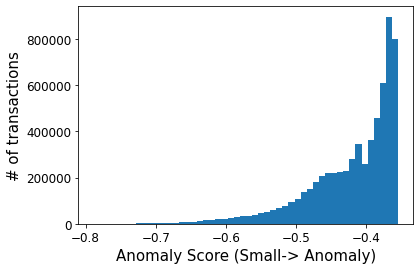

In [29]:
# show anomaly score distribution
plt.hist(scores, bins=50)
plt.ylabel('# of transactions', fontsize=15)
plt.xlabel('Anomaly Score (Small-> Anomaly)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

A lower anomaly score means that there is a higher chance of that data point being an anomaly.

### IDENTIFIED ANOMALIES: List of Top 5 Anomalies
Top n outliers

In [56]:
top_n_outliers = 5
top_n_outlier_indices = np.argpartition(scores, top_n_outliers)[:top_n_outliers].tolist()
top_outlier_entries = transactions.iloc[top_n_outlier_indices, :]
top_outlier_features = features.iloc[top_n_outlier_indices, :]
top_outlier_features

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,hour,changebalanceOrig,changebalanceDest,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
4145988,31866120.39,503019.94,0.0,63539675.65,9.540580e+07,15,-503019.94,3.186612e+07,0,0,0,0,1
4155239,29642476.68,539407.79,0.0,53476069.02,8.311855e+07,15,-539407.79,2.964248e+07,0,0,0,0,1
4136960,29802113.19,550210.01,0.0,48574467.89,1.542623e+08,15,-550210.01,1.056878e+08,0,0,0,0,1
4157895,37387628.10,862621.88,0.0,37843025.59,7.523065e+07,15,-862621.88,3.738763e+07,0,0,0,0,1
4146715,38874009.46,435622.96,0.0,73634878.73,1.125089e+08,15,-435622.96,3.887401e+07,0,0,0,0,1


### ROC Evaluation



Finally, we will  add the AUC score that would be obtained by random guessing.

The predicted anomalies are evaluated against the 'isFraud' columns which represents the ground truth value of whether the given entry constitutes an anomaly or not.

In [39]:
# evaluate isolation forest anomaly scores
fpr_iforest, tpr_iforest, thresholds_iforest = roc_curve(transactions['isFraud'], -scores)
auc_score_iforest = roc_auc_score(transactions['isFraud'], -scores)


In [33]:
def plot_roc_curve(fpr, tpr, name, auc_score):
    plt.plot(fpr, tpr, label=name + ', AUC={}'.format(round(auc_score, 3)))

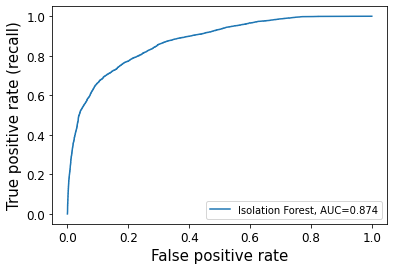

In [57]:
plot_roc_curve(fpr_iforest, tpr_iforest, 'Isolation Forest', auc_score_iforest)

plt.xlabel('False positive rate', fontsize=15)
plt.ylabel('True positive rate (recall)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 12})
plt.legend()

Area Under Curve is calculated as 0.874. This result means our results of prediction of anomaly is pretty successfull. 

### Explanation of Results Using Game Theory
We use a game theory model and calculate Shapley Values for calculation of outcome of a move in a game. Similar approach is used for outcomes of each instance in our IsolationForest model. 

In [41]:
!pip install shap


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import shap

In [44]:
n_random = 5000  # size of random sample
random_indices = np.random.choice(len(features), n_random)
explainer = shap.TreeExplainer(forest)
shap_values_random = explainer.shap_values(features.iloc[random_indices, :])
top_shap_values = explainer.shap_values(top_outlier_features)
random_features = features.iloc[random_indices, :]

In [45]:
def condense(features, shap_values, indices):
    features_condensed = features.drop(columns=['CASH_IN', 'PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT'])
    features_condensed['type'] = transactions['type']
    selected_features_condensed = features_condensed.iloc[indices, :]
    
    shap_values_without_type = shap_values[:, :-5]
    shap_values_type_sum = shap_values[:, -5:].sum(axis=1).reshape(-1, 1)

    shap_values_condensed = np.concatenate([shap_values_without_type, shap_values_type_sum], axis=1)

    return selected_features_condensed, shap_values_condensed

Aggregate categorical 'type' features

In [46]:
random_features_condensed, shap_values_random_condensed = condense(features, shap_values_random, random_indices)
top_outlier_features_condensed, top_shap_values_condensed = condense(features, top_shap_values, top_n_outlier_indices)

SHAP summary plot

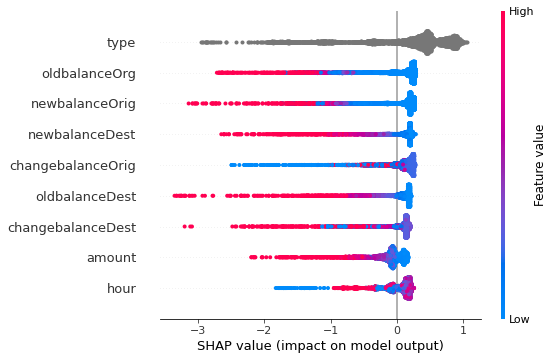

In [47]:
shap.summary_plot(shap_values_random_condensed, random_features_condensed)

SHAP dependence plots

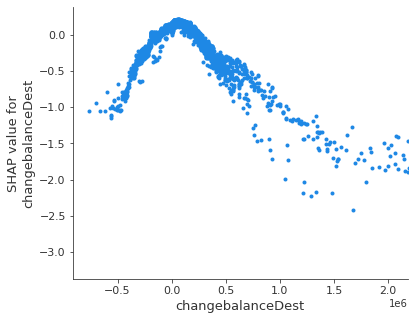

In [49]:
shap.dependence_plot(
    "changebalanceDest",
    shap_values_random,
    random_features,
    interaction_index=None,
    x_jitter=0.5,
    #xmin="percentile(0.5)",
    xmax="percentile(99)"
)

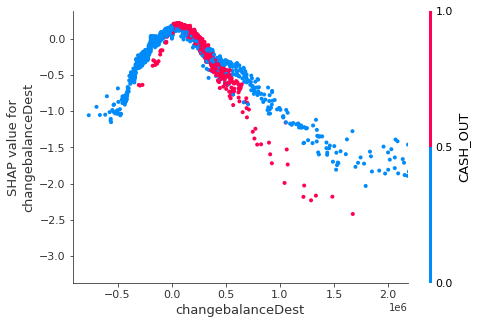

In [53]:
shap.dependence_plot(
    "changebalanceDest",
    shap_values_random,
    random_features,
    interaction_index='CASH_OUT',
    x_jitter=0.5,
    #xmin="percentile(0.5)",
    xmax="percentile(99)"
)

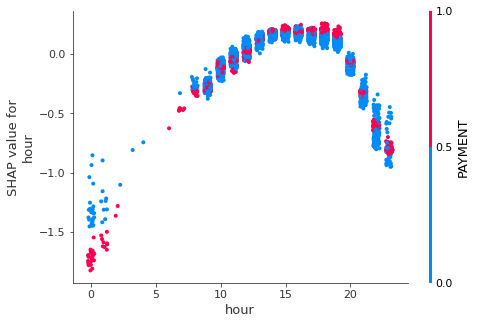

In [51]:
shap.dependence_plot(
    "hour",
    shap_values_random,
    random_features,
    interaction_index='auto',
    x_jitter=0.5,
    #xmin="percentile(1)",
    #xmax="percentile(99)"
)

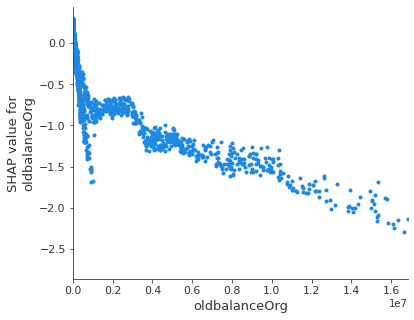

In [52]:
shap.dependence_plot(
    "oldbalanceOrg",
    shap_values_random_condensed,
    random_features_condensed,
    interaction_index=None,
    x_jitter=0.5,
    xmin="percentile(1)",
    xmax="percentile(99)"
)

##Explanation of Top Anomalies
Top n outlier explanations

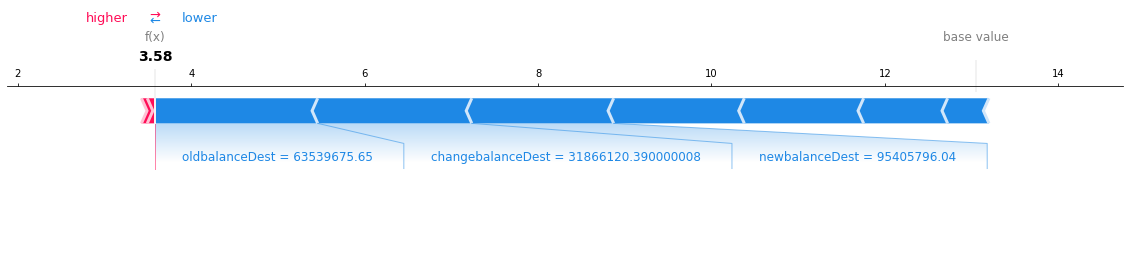

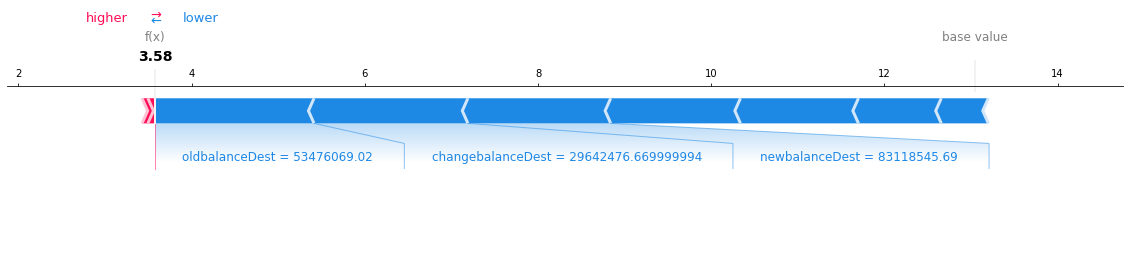

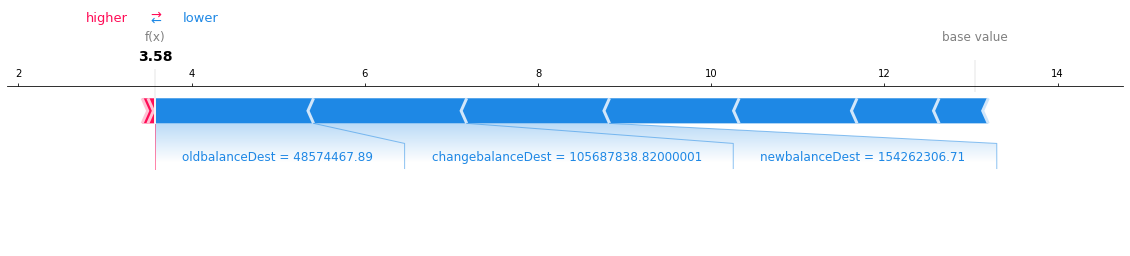

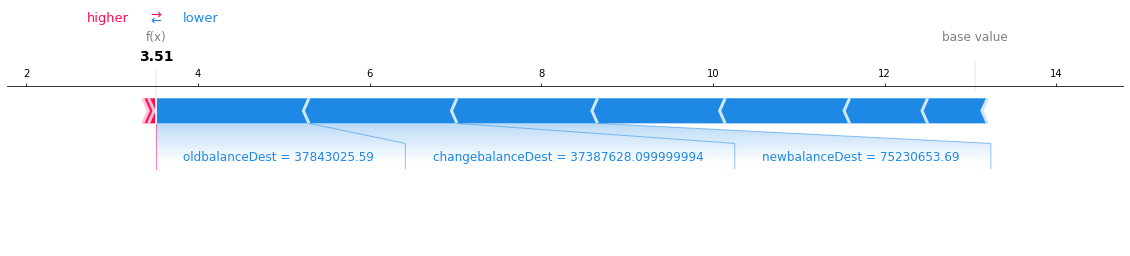

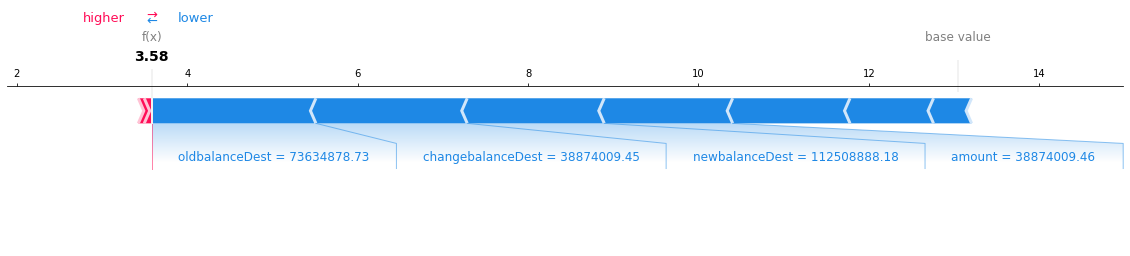

In [58]:
for index in range(top_n_outliers):
    shap.force_plot(explainer.expected_value, top_shap_values_condensed[index, :], top_outlier_features_condensed.iloc[index, :], show=False, matplotlib=True).savefig('scratch.png')